In [4]:
import re
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout, Activation, Flatten, Input, concatenate, Conv1D, GlobalMaxPooling1D, MaxPooling1D



In [5]:
# Text preprocessing function

str_punc = string.punctuation.replace(',', '').replace("'",'')

def clean(text):
    global str_punc
    text = re.sub(r'[^a-zA-Z ]', '', text)
    text = text.lower()
    return text    

In [23]:
# Read dataset & Preprocess text
# dataset = pd.read_csv('../input/isear-emotion/isear_dataset.csv')
df_train = pd.read_csv('data/train.txt', names=['Text', 'Emotion'], sep=';')
df_val = pd.read_csv('data/val.txt', names=['Text', 'Emotion'], sep=';')
df_test = pd.read_csv('data/test.txt', names=['Text', 'Emotion'], sep=';')

df_test = df_test[df_test['Emotion'].isin(['sadness','anger','joy','fear'])]
df_val = df_val[df_val['Emotion'].isin(['sadness','anger','joy','fear'])]
df_train = df_train[df_train['Emotion'].isin(['sadness','anger','joy','fear'])]

X_train = df_train['Text'].apply(clean)
y_train = df_train['Emotion']

X_test = df_test['Text'].apply(clean)
y_test = df_test['Emotion']

X_val = df_val['Text'].apply(clean)
y_val = df_val['Emotion']

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


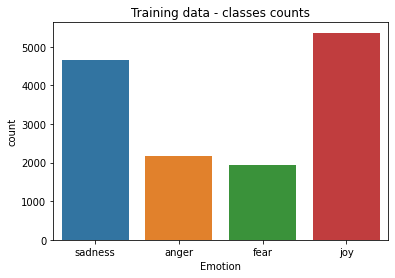

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


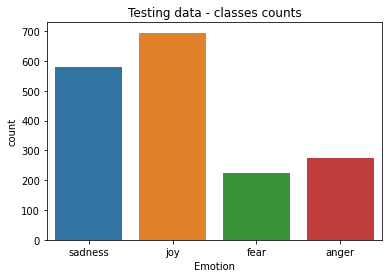

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


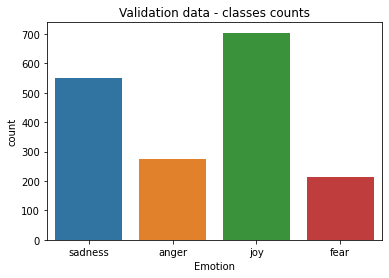

In [24]:
# Visualize classes counts

sns.countplot(y_train)
plt.title("Training data - classes counts")
plt.show()

sns.countplot(y_test)
plt.title("Testing data - classes counts")
plt.show()

sns.countplot(y_val)
plt.title("Validation data - classes counts")
plt.show()

In [8]:
# Encode labels

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)
y_val = le.transform(y_val)

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

In [9]:

# Tokenize words
tokenizer = Tokenizer()
tokenizer.fit_on_texts(pd.concat([X_train, X_test], axis=0))


sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)
sequences_val = tokenizer.texts_to_sequences(X_val)

X_train = pad_sequences(sequences_train, maxlen=256, truncating='pre')
X_test = pad_sequences(sequences_test, maxlen=256, truncating='pre')
X_val = pad_sequences(sequences_val, maxlen=256, truncating='pre')

vocabSize = len(tokenizer.index_word) + 1
print(f"Vocabulary size = {vocabSize}")

Vocabulary size = 12161


In [10]:
# Embedding
max_features = 20000
maxlen = 100
embedding_size = 128

# Convolution
kernel_size = 5
filters = 64
pool_size = 4

# LSTM
lstm_output_size = 70

# Training
#batch_size = 30
#epochs = 2

In [11]:
# Embedding
max_features = vocabSize
maxlen = X_train.shape[1]
embedding_size = 200

# Convolution
kernel_size = 5
filters = 128
pool_size = 4

# LSTM
lstm_output_size = 128

# Training
#batch_size = 30
#epochs = 2

In [12]:
print('Build model...')

model = Sequential()
model.add(Embedding(vocabSize, embedding_size, input_length=X_train.shape[1]))
model.add(Dropout(0.25))
model.add(Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu',
                 strides=1))
model.add(MaxPooling1D(pool_size=pool_size))
model.add(LSTM(lstm_output_size))
model.add(Dense(4))
model.add(Activation('softmax'))
model.summary()

Build model...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 256, 200)          2432200   
                                                                 
 dropout (Dropout)           (None, 256, 200)          0         
                                                                 
 conv1d (Conv1D)             (None, 252, 128)          128128    
                                                                 
 max_pooling1d (MaxPooling1D  (None, 63, 128)          0         
 )                                                               
                                                                 
 lstm (LSTM)                 (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 4)                 516       
                                         

In [13]:
adam = Adam(learning_rate=0.005)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])


In [14]:
callback = EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True,
)

In [15]:
# Fit model
history = model.fit(X_train,
                    y_train,
                    validation_data=(X_val, y_val),
                    verbose=1,
                    batch_size=256,
                    epochs=30,
                    callbacks=[callback]
                   )

Epoch 1/30
35/35 [==============================] - 16s 109ms/step - loss: 1.1038 - accuracy: 0.5016 - val_loss: 0.5557 - val_accuracy: 0.7972
Epoch 2/30
35/35 [==============================] - 3s 79ms/step - loss: 0.3958 - accuracy: 0.8325 - val_loss: 0.3444 - val_accuracy: 0.8817
Epoch 3/30
35/35 [==============================] - 3s 81ms/step - loss: 0.1251 - accuracy: 0.9617 - val_loss: 0.2831 - val_accuracy: 0.9150
Epoch 4/30
35/35 [==============================] - 3s 89ms/step - loss: 0.0545 - accuracy: 0.9825 - val_loss: 0.2455 - val_accuracy: 0.9265
Epoch 5/30
35/35 [==============================] - 3s 88ms/step - loss: 0.0229 - accuracy: 0.9930 - val_loss: 0.2930 - val_accuracy: 0.9144
Epoch 6/30
35/35 [==============================] - 3s 87ms/step - loss: 0.0144 - accuracy: 0.9959 - val_loss: 0.3462 - val_accuracy: 0.9161
Epoch 7/30
35/35 [==============================] - 3s 88ms/step - loss: 0.0105 - accuracy: 0.9966 - val_loss: 0.3013 - val_accuracy: 0.9316


In [16]:
model.evaluate(X_test, y_test, verbose=1)

56/56 [==============================] - 1s 14ms/step - loss: 0.2326 - accuracy: 0.9268


[0.23262926936149597, 0.9267605543136597]

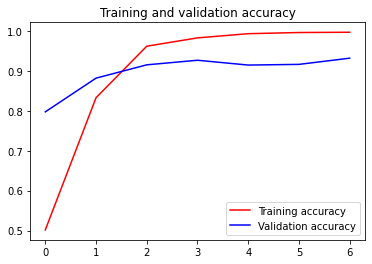

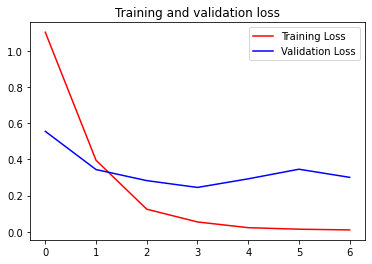

In [17]:
# Visualize Loss & Accuracy

%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [18]:
# Classify custom sample
def predict(text):
    print(sentence)
    sentence = clean(sentence)
    sentence = tokenizer.texts_to_sequences([sentence])
    sentence = pad_sequences(sentence, maxlen=256, truncating='pre')
    result = le.inverse_transform(np.argmax(model.predict(sentence), axis=-1))[0]
    proba =  np.max(model.predict(sentence))
    print(f"{result} : {proba}\n\n")

In [19]:
import pickle
with open('tokenizer.pickle', 'wb') as f:
    pickle.dump(tokenizer, f)
    
with open('labelEncoder.pickle', 'wb') as f:
    pickle.dump(le, f)
    
    
model.save('Emotion Detection.h5')